In [1]:
# use gpd_2023 environment

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pickle

import pandas as pd

# Test: Df to vol, vol to df

Lest check that we can load the df, create a volumn, and then recreate af df again

### Functions

In [2]:
def df_to_vol(df):
    """
    Converts a DataFrame into a 4D volume array for spatial-temporal data representation.
    The volume array is [height, width, n_months, n_features].

    Args:
        df (pd.DataFrame): The input DataFrame containing spatial-temporal data with columns
                           'abs_row', 'abs_col', 'abs_month', 'pg_id', 'col', 'row',
                           'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', and 'ln_os_best'.

    Returns:
        np.ndarray: The volume representation of the DataFrame with shape 
                    [n_months, height, width, n_features].
                    The specific shape will be [n_months, 180, 180, 8].
    """
    month_first = df['month_id'].min()
    month_last = df['month_id'].max()
    month_range = month_last - month_first + 1
    space_range = 180
    features_num = 8  # Should match the number of features in the DataFrame

    vol = np.zeros([space_range, space_range, month_range, features_num])

    vol[df['abs_row'], df['abs_col'], df['abs_month'], 0] = df['pg_id']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 1] = df['col']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 2] = df['row']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 3] = df['month_id']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 4] = df['c_id']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 5] = df['ln_sb_best']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 6] = df['ln_ns_best']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 7] = df['ln_os_best']

    vol = np.flip(vol, axis=0)  # Flip the rows, so north is up.
    vol = np.transpose(vol, (2, 0, 1, 3))  # Move the month dimension to the front.

    print(f'Volume of shape {vol.shape} created. Should be (n_months, 180, 180, 8)')

    return vol


In [3]:
def vol_to_df(vol):
    """
    Converts a 4D volume array back into a DataFrame for spatial-temporal data.
    The volume array is expected to have dimensions [n_months, height, width, n_features].

    Args:
        vol (np.ndarray): The input 4D volume array to be converted, with shape 
                          [n_months, height, width, n_features].

    Returns:
        pd.DataFrame: The DataFrame representation of the volume array containing columns
                      'pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best'.
                      DataFrame is cleaned to remove rows where 'pg_id' is 0.
    """
    n_months, height, width, n_features = vol.shape

    df = pd.DataFrame({
        'pg_id': vol[:, :, :, 0].flatten(),
        'col': vol[:, :, :, 1].flatten(),
        'row': vol[:, :, :, 2].flatten(),
        'month_id': vol[:, :, :, 3].flatten(),
        'c_id': vol[:, :, :, 4].flatten(),
        'ln_sb_best': vol[:, :, :, 5].flatten(),
        'ln_ns_best': vol[:, :, :, 6].flatten(),
        'ln_os_best': vol[:, :, :, 7].flatten()
    })

    # Correct the data types
    df['pg_id'] = df['pg_id'].astype(int)
    df['col'] = df['col'].astype(int)
    df['row'] = df['row'].astype(int)
    df['month_id'] = df['month_id'].astype(int)
    df['c_id'] = df['c_id'].astype(int)

    # Remove rows where 'pg_id' is 0
    df = df[df['pg_id'] != 0]

    print(f'DataFrame of shape {df.shape} created. Should be (n_months * 180 * 180, 8)')

    return df


In [4]:
def df_vol_test(df, vol):
    """
    Unit test to verify the conversion between DataFrame and volume array.
    Checks if the original DataFrame and the DataFrame created from the volume are equivalent.

    Args:
        df (pd.DataFrame): The original DataFrame.
        vol (np.ndarray): The 4D volume array created from the DataFrame.

    Returns:
        None: Prints the result of the equivalence test.
    """
    # Make a copy of the original DataFrame
    df_copy = df.copy()

    # Proof of concept: Check if the copy is the same as the original
    print("Original DataFrame equals its copy:", df.equals(df_copy))

    # Convert the volume back into a DataFrame
    df_recreated = vol_to_df(vol)

    # Trim the original DataFrame to match the features of the recreated DataFrame
    df_trimmed = df[['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']]

    # Sort both DataFrames by 'pg_id' and 'month_id'
    df_trimmed = df_trimmed.sort_values(by=['pg_id', 'month_id'])
    df_recreated = df_recreated.sort_values(by=['pg_id', 'month_id'])

    # Reset the index to ensure alignment
    df_trimmed = df_trimmed.reset_index(drop=True)
    df_recreated = df_recreated.reset_index(drop=True)

    # Check if the two DataFrames are the same
    is_equal = df_trimmed.equals(df_recreated)
    print("Trimmed original DataFrame equals recreated DataFrame from volume:", is_equal)


In [5]:
def plot_vol(vol, month_range):
    """
    Plots slices of the 4D volume array for the specified month range.
    Displays different feature maps for each time step in separate subplots.

    Args:
        vol (np.ndarray): The input 4D volume array with shape [n_months, height, width, n_features].
        month_range (int): The number of slices (time steps) to plot.

    Returns:
        None: Displays the plots.
    """
    features_titles = ['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']
    n_features = vol.shape[-1]

    # get sub_df of the lasst month_range months
    vol = vol[-month_range:, :, :, :]

    for i in range(month_range):
        fig, ax = plt.subplots(1, n_features, figsize=(20, 4))
        
        for j in range(min(n_features, vol.shape[-1])):  # Handle cases where there are fewer than 7 features
            im = ax[j].imshow(vol[i, :, :, j], cmap='rainbow', vmin= vol[:, :, :, j].min(), vmax= vol[:, :, :, j].max())
            ax[j].set_title(features_titles[j] if j < len(features_titles) else f'Feature {j}')
            # plt.colorbar(im, ax=ax[j])

        # Adding title with specific adjustment
        fig.suptitle(f'Time Step {i + 1}', fontsize=16, y=1.05)  # Adjust `y` for title position

        # remove ticks
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])

        # Adjust layout
        plt.subplots_adjust(left=0.1, right=1, top=0.85, bottom=0.55, wspace=0.2, hspace=-0)
        plt.tight_layout(pad=2.0, rect=[0, 0, 1, 0.9])  # `rect` adjusts the position of subplots
        
        plt.show()


### Execute


Volume of shape (324, 180, 180, 8) created. Should be (n_months, 180, 180, 8)
Original DataFrame equals its copy: True
DataFrame of shape (4247640, 8) created. Should be (n_months * 180 * 180, 8)
Trimmed original DataFrame equals recreated DataFrame from volume: True


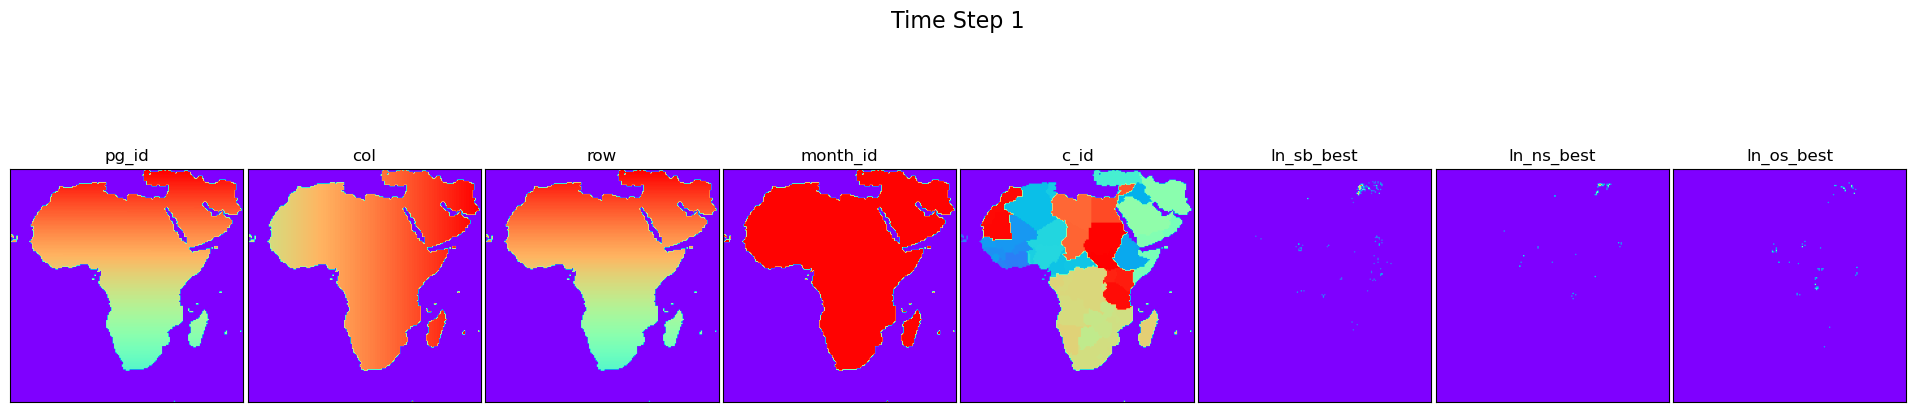

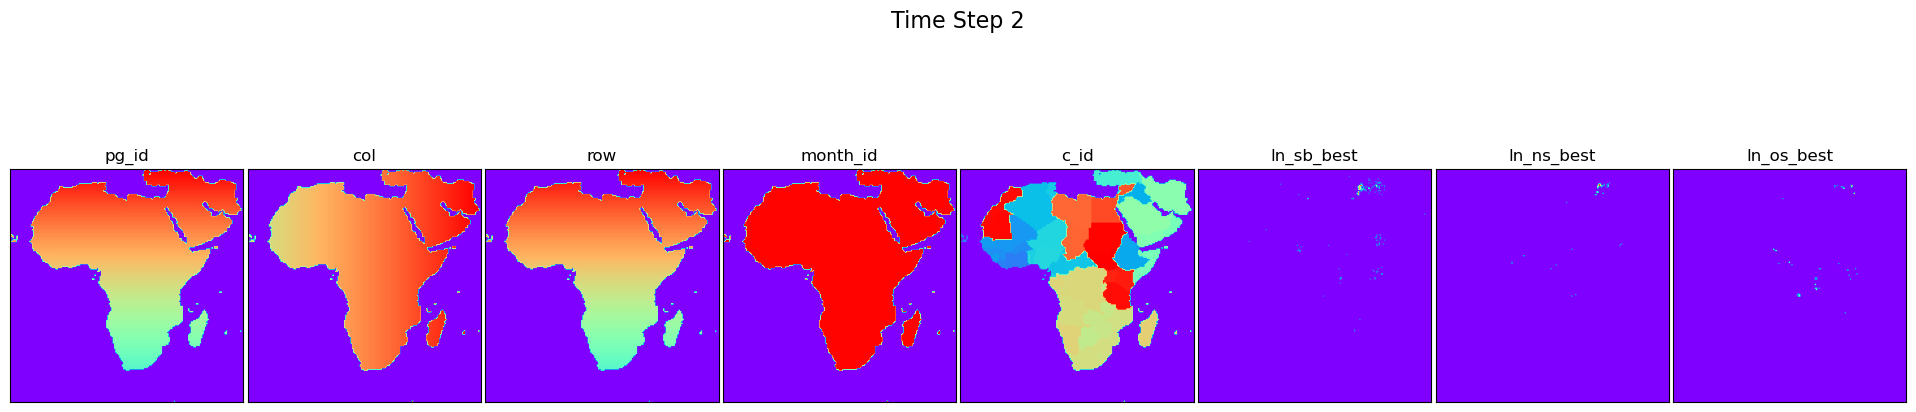

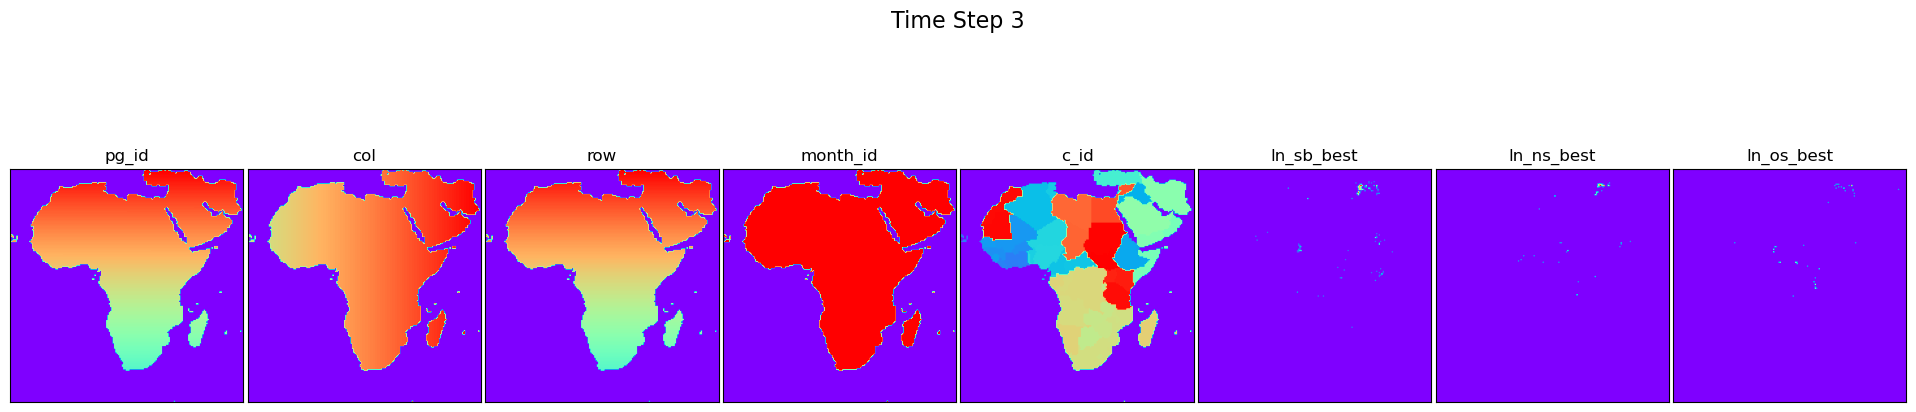

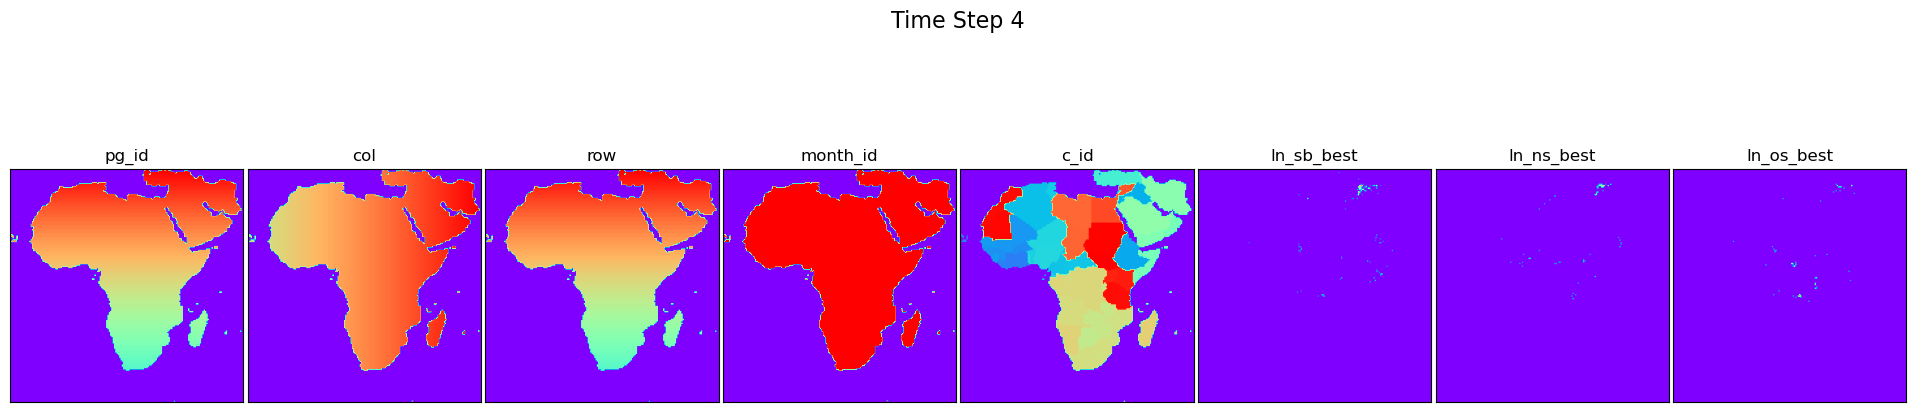

In [6]:
# set the path to the raw data
PATH = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_data.pkl"

# get the df from the pickle file in raw_data
df = pd.read_pickle(PATH)

# turn the df1 into a volume
vol = df_to_vol(df)

df_vol_test(df, vol)

plot_vol(vol, 4)

# forecast storage test
Now we test how we can make a storage array for the 4D forcast

### Functions

In [7]:
def generate_fake_vol(vol, month_range=36):
    """
    Generates a fake prediction volume for testing purposes by extracting the last three features from the input volume.
    Assumes the last three features represent `sb`, `ns`, and `os`.

    Args:
        vol (np.ndarray): The input 4D volume array with shape [n_months, height, width, n_features].
        n_months (int): The number of months to include in the fake volume. Default is 36.

    Returns:
        np.ndarray: A volume array with the last three features, shape [32, height, width, 3].
                    Represents a subset of the original volume for testing.
    """
    # Extract the last three features from the volume
    fake_vol = vol[-month_range:, :, :, 5:]  

    return fake_vol


In [8]:
def make_forecast_storage_vol(df, month_range = 36):
    """
    Creates a forecast storage volume based on the last month of data in the DataFrame.
    The volume is repeated for the specified `month_range` with incrementally adjusted month IDs.

    Args:
        df (pd.DataFrame): The input DataFrame containing spatial-temporal data.
                           Expected columns include 'abs_row', 'abs_col', 'abs_month', 'pg_id', 'col', 
                           'row', 'month_id', 'c_id'.
        month_range (int): The number of months to forecast into the future. Default is 36.

    Returns:
        np.ndarray: The forecast storage volume with shape [month_range, 180, 180, 5].
                    Each time slice in the volume represents a future month based on the last month of data.
    """
    # Infer the last month_id from the DataFrame
    last_month_id = df['month_id'].max()

    # Create a sub DataFrame of only the last month
    sub_df = df[df['month_id'] == last_month_id].copy()

    # Initialize the volume array
    space_range = 180
    features_num = 5  # Adjust this based on the number of features you have

    # Create the zero array with only the last month
    vol = np.zeros([space_range, space_range, 1, features_num])

    # Adjust abs_month to 0 for the initial volume
    sub_df['adjusted_abs_month'] = 0

    # Populate the volume array with the data from the DataFrame
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 0] = sub_df['pg_id']
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 1] = sub_df['col']
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 2] = sub_df['row']
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 3] = sub_df['month_id'] 
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 4] = sub_df['c_id']

    # Stack the volume to the desired month range
    vol = np.repeat(vol, month_range, axis=2)

    # Adjust the month_id with an increment of 1
    for i in range(month_range):
        vol[:, :, i, 3] = last_month_id + i + 1 # to get one month after the last observed month

    # Reorient and transpose
    vol = np.flip(vol, axis=0)
    vol = np.transpose(vol, (2, 0, 1, 3))

    print(f'Volume of shape {vol.shape} created. Should be ({month_range}, 180, 180, {features_num})')

    return vol

In [9]:
def merge_vol(forecast_storage_vol, vol_fake):
    """
    Merges a forecast volume with an existing forecast storage volume.
    Combines the features from `vol_fake` with `vol` along the feature axis.

    Args:
        vol (np.ndarray): The forecast storage volume with shape [n_months, height, width, n_features].
        vol_fake (np.ndarray): The forecast volume to be merged with shape [n_months, height, width, n_features_fake].

    Returns:
        np.ndarray: The merged volume with shape [n_months, height, width, n_features + n_features_fake].
    """
    # Merge the forecast volume with the storage volume along the feature axis
    full_vol = np.concatenate([forecast_storage_vol, vol_fake], axis=-1)

    # print the shape of the full volume
    print(f'Volume of shape {full_vol.shape} created. Should be ({forecast_storage_vol.shape[0]}, 180, 180, {forecast_storage_vol.shape[3] + vol_fake.shape[3]})')

    return full_vol


In [10]:
def check_vol_equal(vol, full_vol):
    """
    Unit test to verify the merging of two volumes.
    Checks if the original volume and the merged volume are equivalent.

    Args:
        vol (np.ndarray): The original volume.
        full_vol (np.ndarray): The merged volume.

    Returns:
        None: Prints the result of the equivalence test.
    """

    #print the shape of the volumes
    print(vol.shape)
    print(full_vol.shape)

    # trim original volume to the same shape as the full volume - ie. the last n months
    month_range = full_vol.shape[0]
    vol_trimmed = vol[-month_range:, :, :, :]

    # print the shape of the trimmed volume
    print(vol_trimmed.shape)

    # now go through each feature individually and check if they are the same

    list_features = ['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']

    for i in range(vol_trimmed.shape[-1]):
        print(f"Feature {i}, {list_features[i]} equal:", np.array_equal(vol_trimmed[:, :, :, i], full_vol[:, :, :, i]))


In [11]:
def plot_vol_comperison(vol, new_vol, month_range = 36):


    features_titles = ['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']
    n_features = vol.shape[-1]

    # get sub_df of the lasst month_range months
    vol = vol[-month_range:, :, :, :]

    for i in range(month_range):
        fig, ax = plt.subplots(2, n_features, figsize=(20, 4))
        
        for j in range(min(n_features, vol.shape[-1])):  # Handle cases where there are fewer than 7 features

            # plot the original volume
            im = ax[j].imshow(vol[i, :, :, j], cmap='rainbow', vmin= vol[:, :, :, j].min(), vmax= vol[:, :, :, j].max())
            ax[j].set_title(features_titles[j] if j < len(features_titles) else f'Feature {j}')
            # plt.colorbar(im, ax=ax[j])

        # Adding title with specific adjustment
        fig.suptitle(f'Time Step {i + 1}', fontsize=16, y=1.05)  # Adjust `y` for title position

        # remove ticks
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])

        # Adjust layout
        plt.subplots_adjust(left=0.1, right=1, top=0.85, bottom=0.55, wspace=0.2, hspace=-0)
        plt.tight_layout(pad=2.0, rect=[0, 0, 1, 0.9])  # `rect` adjusts the position of subplots
        
        plt.show()

In [12]:
def plot_vol_comparison(vol, new_vol, month_range=36):
    """
    Plots a comparison of slices from two 4D volume arrays for the specified month range.
    Displays different feature maps for each time step in separate subplots for both volumes.

    Args:
        vol (np.ndarray): The original 4D volume array with shape [n_months, height, width, n_features].
        new_vol (np.ndarray): The new 4D volume array to compare with, with the same shape as `vol`.
        month_range (int): The number of slices (time steps) to plot. Default is 36.

    Returns:
        None: Displays the plots.
    """
    features_titles = ['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']
    n_features = vol.shape[-1]

    # Ensure the volumes cover the last month_range months
    vol = vol[-month_range:, :, :, :]
    new_vol = new_vol[-month_range:, :, :, :]

    for i in range(month_range):
        fig, ax = plt.subplots(2, n_features, figsize=(20, 7))  # 2 rows, n_features columns
        
        for j in range(n_features):  # Adjusted to use n_features directly
            # Plot the original volume in the first row
            im1 = ax[0, j].imshow(vol[i, :, :, j], cmap='rainbow',
                                  vmin=vol[:, :, :, j].min(), vmax=vol[:, :, :, j].max())
            ax[0, j].set_title(features_titles[j] if j < len(features_titles) else f'Feature {j}')
            #plt.colorbar(im1, ax=ax[0, j])

            # Plot the new volume in the second row
            im2 = ax[1, j].imshow(new_vol[i, :, :, j], cmap='rainbow',
                                  vmin=new_vol[:, :, :, j].min(), vmax=new_vol[:, :, :, j].max())
            ax[1, j].set_title(f'New {features_titles[j]}' if j < len(features_titles) else f'New Feature {j}')
            #plt.colorbar(im2, ax=ax[1, j])

        # Adding title with specific adjustment
        fig.suptitle(f'Time Step {i + 1}', fontsize=16, y=1.05)  # Adjust `y` for title position

        # Remove ticks
        for a in ax.flat:
            a.set_xticks([])
            a.set_yticks([])

        # Adjust layout
        plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0.2, hspace=0.4)
        plt.tight_layout(pad=2.0, rect=[0, 0, 1, 0.95])  # `rect` adjusts the position of subplots
        
        plt.show()


### Execute

In [13]:
month_range = 32

vol_fake = generate_fake_vol(vol, month_range=month_range)

#print shape of vol_fake
print(vol_fake.shape)

# make the forecast storage volume
forecast_storage_vol = make_forecast_storage_vol(df, month_range=month_range)

#print shape of forecast_storage_vol
print(forecast_storage_vol.shape)

# merge the forecast storage volume with the forecast volume
new_vol = merge_vol(forecast_storage_vol, vol_fake)

#print shape of full_vol
print(new_vol.shape)

# Check that the full vol is equal to the original vol (sliced correctly)
check_vol_equal(vol, new_vol)

# plot the volume slices
# plot_vol_comparison(vol, new_vol, month_range=month_range) # works and cornfirms that the two volumes are the same (except for month_id, which is expected)

(32, 180, 180, 3)
Volume of shape (32, 180, 180, 5) created. Should be (32, 180, 180, 5)
(32, 180, 180, 5)
Volume of shape (32, 180, 180, 8) created. Should be (32, 180, 180, 8)
(32, 180, 180, 8)
(324, 180, 180, 8)
(32, 180, 180, 8)
(32, 180, 180, 8)
Feature 0, pg_id equal: True
Feature 1, col equal: True
Feature 2, row equal: True
Feature 3, month_id equal: False
Feature 4, c_id equal: True
Feature 5, ln_sb_best equal: True
Feature 6, ln_ns_best equal: True
Feature 7, ln_os_best equal: True


So we can now construct the vol form a df, and we can reconstruct the df from the vol. We can also make a forecasting storage and merge that with (fake) predictions to get a vol similar to the original vol. Now must take that back to a df. 

# new_vol to df

Now, create a new vol and make into a df and ceck that this df can corrospond to the original df

In [14]:
# Lets start from scracth
PATH = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_data.pkl"
df = pd.read_pickle(PATH)

vol = df_to_vol(df)

vol_fake = generate_fake_vol(vol, month_range=month_range)

forecast_storage_vol = make_forecast_storage_vol(df, month_range=month_range)

new_vol = merge_vol(forecast_storage_vol, vol_fake)

check_vol_equal(vol, new_vol)

df_new = vol_to_df(new_vol)

Volume of shape (324, 180, 180, 8) created. Should be (n_months, 180, 180, 8)
Volume of shape (32, 180, 180, 5) created. Should be (32, 180, 180, 5)
Volume of shape (32, 180, 180, 8) created. Should be (32, 180, 180, 8)
(324, 180, 180, 8)
(32, 180, 180, 8)
(32, 180, 180, 8)
Feature 0, pg_id equal: True
Feature 1, col equal: True
Feature 2, row equal: True
Feature 3, month_id equal: False
Feature 4, c_id equal: True
Feature 5, ln_sb_best equal: True
Feature 6, ln_ns_best equal: True
Feature 7, ln_os_best equal: True
DataFrame of shape (419520, 8) created. Should be (n_months * 180 * 180, 8)


In [15]:
print(df["month_id"].max())
(df_new["month_id"].min())


444


445

In [16]:
df_new

,pg_id,col,row,month_id,c_id,ln_sb_best,ln_ns_best,ln_os_best
284,190494,414,265,445,89,0.0,0.0,0.0
285,190495,415,265,445,89,0.0,0.0,0.0
286,190496,416,265,445,89,0.0,0.0,0.0
297,190507,427,265,445,96,0.0,0.0,0.0
298,190508,428,265,445,96,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1032222,80332,412,112,476,163,0.0,0.0,0.0
1032389,79599,399,111,476,163,0.0,0.0,0.0
1032390,79600,400,111,476,163,0.0,0.0,0.0
1032391,79601,401,111,476,163,0.0,0.0,0.0


In [34]:
month_range = 32
month_max = df["month_id"].max()
month_array = np.arange(month_max - month_range +1, month_max+1)
df_sub = df[df['month_id'].isin(month_array)]

# only keep the features that are in the new volume
df_sub = df_sub[['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']]

df_sub 

,pg_id,col,row,month_id,c_id,ln_sb_best,ln_ns_best,ln_os_best
5401320,62356,436,87,413,163,0.0,0.0,0.0
5401321,79599,399,111,413,163,0.0,0.0,0.0
5401322,79600,400,111,413,163,0.0,0.0,0.0
5401323,79601,401,111,413,163,0.0,0.0,0.0
5401324,80317,397,112,413,163,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
5820835,190496,416,265,444,89,0.0,0.0,0.0
5820836,190507,427,265,444,96,0.0,0.0,0.0
5820837,190508,428,265,444,96,0.0,0.0,0.0
5820838,190510,430,265,444,96,0.0,0.0,0.0


In [35]:
# now sort both dataframes by pg_id and month_id
df_sub = df_sub.sort_values(by=['pg_id', 'month_id'])
df_new = df_new.sort_values(by=['pg_id', 'month_id'])

# check which columns are not equal 
for i in range(df_sub.shape[1]):
    print(f"Feature {i}, {df_sub.columns[i]} equal:", np.array_equal(df_sub.iloc[:, i], df_new.iloc[:, i]))

Feature 0, pg_id equal: True
Feature 1, col equal: True
Feature 2, row equal: True
Feature 3, month_id equal: False
Feature 4, c_id equal: True
Feature 5, ln_sb_best equal: True
Feature 6, ln_ns_best equal: True
Feature 7, ln_os_best equal: True
